In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving dataset_clean_Bandung_ITB.xlsx to dataset_clean_Bandung_ITB.xlsx


In [ ]:
data_bandung = list(uploaded.keys())[0]
df = pd.read_excel(data_bandung)
df.iloc[:, 3:] = df.iloc[:, 3:].apply(pd.to_numeric, errors='coerce')
# semua baris dan dari kolom 3+1 sampai akhir. Terapkan semua nilai ke numeric dan jika nilainya tidak dapat dikonversi
# nyatakan sebagai Nan
print(df)

      date_pm25 time_pm25      PM25        PM10        PM1
0    2023-10-11  00:00:00  31.71706   39.035572  51.823751
1    2023-10-11  01:00:00  65.55853   77.817786  59.486875
2    2023-10-11  02:00:00  99.40000  116.600000  67.150000
3    2023-10-11  03:00:00  66.40000   78.800000  47.100000
4    2023-10-11  04:00:00  50.20000   65.590000  34.900000
...         ...       ...       ...         ...        ...
1306 2023-12-04  19:00:00  34.90000   44.850000  44.981000
1307 2023-12-04  20:00:00  32.85000   41.500000  45.160000
1308 2023-12-04  21:00:00  34.15000   44.400000  45.008000
1309 2023-12-04  22:00:00  39.00000   52.200000  26.850000
1310 2023-12-04  23:00:00  40.90000   54.300000  45.134000

[1311 rows x 5 columns]


In [ ]:
# memisahkan fitur input dan output
input_features = ['PM25','PM10']
output_features = ['PM25','PM10']

In [ ]:
# x mengambil data pada df yang fiturnya ada di input_features
# y mengambil data pada df yang fiturnya ada di output_features
x = df[input_features].values
y = df[output_features].values

In [ ]:
# normalisasi supaya skalanya konsisten 0-1
# inisialisasi dulu
scaler = MinMaxScaler()

# x_scaled dan y_scaled ini adalah hasil tranformasi
x_scaled = scaler.fit_transform(x)
y_scaled = scaler.fit_transform(y)

In [ ]:
# Pemisahan data uji, data latih

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size = 0.2, shuffle=False)
# size disini sebagai berapa banyak data yang akan kita gunakan sebagai data testing
# 0.2 artinya 20% data akan digunakan sebagai data uji dan 80% sebagai data latih
# karena kita menggunakan data time series, maka harus ditambahakan shuffle sbg mencegah terjadinya pengacakan data
# saat kita membagi data menjadi data uji dan data latih, urutannya tidak akan teracak

In [ ]:
# timesteps ini adalah panjangnya rentang waktu yang akan digunakan input model LSTM
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

timesteps = 24
# menggunakan data 24 jam sebelumnya menjadi input LSTM

n_features_input = len(input_features)
n_features_output = len(output_features)

In [ ]:
# mendefinisikan fungsi
def create_sequences(x, y, time_steps) :
  x_seq, y_seq = [], []

# sebelum mengembalikan nilai para seq, kita akan melakukan iterasi
  for i in range(len(x)-time_steps) : #pengurangan dg timesteps krn data paling terakhir tidak akan bisa di proses
    x_seq.append(x[i : i + time_steps])
    y_seq.append(y[i + time_steps ])

  return np.array(x_seq), np.array(y_seq)

In [ ]:
x_train_seq, y_train_seq = create_sequences(x_train, y_train, timesteps)
x_test_seq, y_test_seq = create_sequences(x_test, y_test, timesteps)

In [ ]:
# MODEL LSTM
model = Sequential()

model.add(LSTM(120, input_shape=(timesteps, n_features_input), return_sequences=True))
# model.add(LSTM(120, return_sequences=True))  # Layer LSTM tambahan
model.add(LSTM(120)) # Layer LSTM lainnya


#layer output
model.add(Dense(n_features_output))

In [ ]:
model.compile(optimizer='adam', loss='mae') # mae bisa ganti rmse atau mse

In [ ]:
#fitting, bangun model
hist = model.fit(x_train_seq, y_train_seq, epochs=100, batch_size=30, validation_data=(x_test_seq, y_test_seq),  callbacks=[early_stopping])

Epoch 1/100
35/35 [==============================] - 12s 93ms/step - loss: 0.1749 - val_loss: 0.1073
Epoch 2/100
35/35 [==============================] - 2s 67ms/step - loss: 0.1336 - val_loss: 0.0819
Epoch 3/100
35/35 [==============================] - 4s 109ms/step - loss: 0.1145 - val_loss: 0.0878
Epoch 4/100
35/35 [==============================] - 3s 95ms/step - loss: 0.1045 - val_loss: 0.0745
Epoch 5/100
35/35 [==============================] - 2s 68ms/step - loss: 0.1040 - val_loss: 0.0862
Epoch 6/100
35/35 [==============================] - 2s 69ms/step - loss: 0.0945 - val_loss: 0.0682
Epoch 7/100
35/35 [==============================] - 2s 68ms/step - loss: 0.0872 - val_loss: 0.0647
Epoch 8/100
35/35 [==============================] - 3s 85ms/step - loss: 0.0853 - val_loss: 0.0754
Epoch 9/100
35/35 [==============================] - 3s 99ms/step - loss: 0.0799 - val_loss: 0.0593
Epoch 10/100
35/35 [==============================] - 2s 66ms/step - loss: 0.0761 - val_loss: 0.05

[0.17487989366054535, 0.13363894820213318, 0.11448676139116287, 0.1044812723994255, 0.10401144623756409, 0.09449565410614014, 0.08723195642232895, 0.08531220257282257, 0.07992088049650192, 0.07605429738759995, 0.07720556855201721, 0.07672113925218582, 0.0747218132019043, 0.0770520493388176, 0.07386106252670288, 0.07641281187534332, 0.07453710585832596, 0.07519084215164185, 0.07454648613929749, 0.07603428512811661, 0.07426353543996811, 0.07301225513219833, 0.0740598514676094, 0.07257650792598724, 0.07503897696733475, 0.07294735312461853, 0.07428531348705292, 0.07269813865423203, 0.0735456570982933, 0.07240316271781921, 0.07263465225696564, 0.073096863925457]


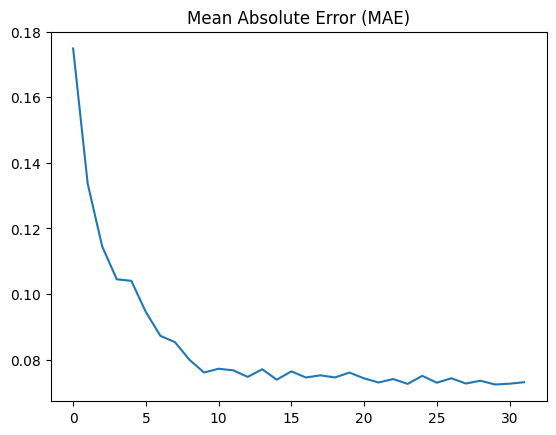

In [ ]:
model_history = hist.history
loss = model_history['loss']
print(loss)



plt.figure()
plt.plot(loss, label='MAE')
plt.title('Mean Absolute Error (MAE)')
plt.show()

In [ ]:
predictions = model.predict(x_test_seq)
# mengembalikan data prediksi ke semula
predictions = scaler.inverse_transform(predictions)

8/8 [==============================] - 1s 20ms/step


In [ ]:
# mengembalikan nilai y_test
y_test_original = scaler.inverse_transform(y_test_seq)

In [ ]:
# menghitung MAE prediksi atau mean absolute eror dari testing
mae = np.mean(np.abs(predictions-y_test_original), axis=0)

In [ ]:
# iterasi untuk menampilkan MAE masing-masing fitur
for i, feature in enumerate(output_features):
  print("MAE untuk fitur ", feature, " : ", mae[i])

MAE untuk fitur  PM25  :  5.77908997341779
MAE untuk fitur  PM10  :  7.664910305517984


In [ ]:
# menentukan batas, modelnya akurat atau tidak

threshold_mae_PM25 = (df['PM25'].max() - df['PM25'].min()) * 10 / 100
print("threshold_mae_PM25 : ", threshold_mae_PM25)

threshold_mae_PM10 = (df['PM10'].max() - df['PM10'].min()) * 10 / 100
print("threshold_mae_PM10 : ", threshold_mae_PM10)


threshold_mae_PM25 :  11.155
threshold_mae_PM10 :  12.255


<function matplotlib.pyplot.show(close=None, block=None)>

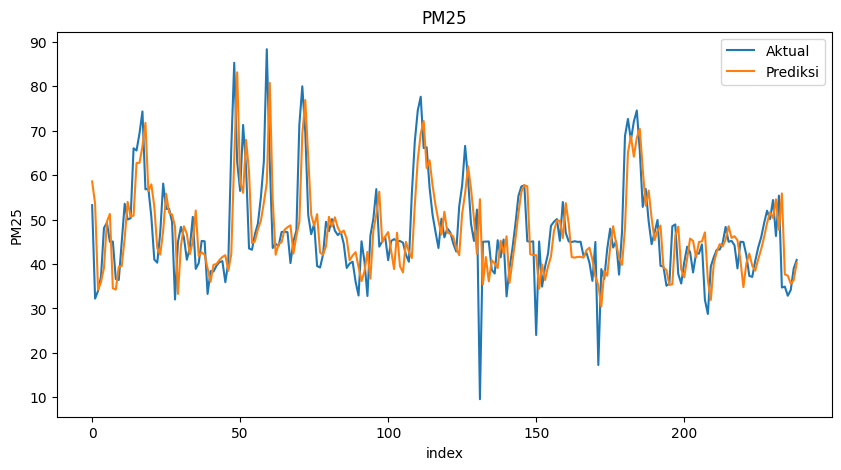

In [ ]:
# Plot untuk PM25

target_index = 0 #PM25

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('PM25')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

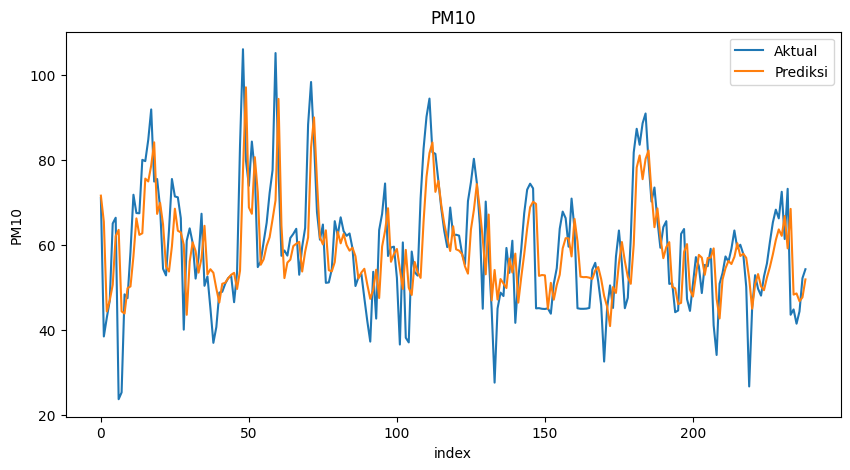

In [ ]:
# Plot untuk PM10

target_index = 1 #PM10

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('PM10')
plt.legend()
plt.show

In [ ]:
# Ambil 24 waktu terakhir dari data Anda
last_24_timesteps = df[input_features].values[-timesteps:]

# Normalisasi menggunakan scaler
last_24_timesteps_scaled = scaler.transform(last_24_timesteps)

# Inisialisasi array untuk menyimpan hasil prediksi
future_predictions = []

# Lakukan prediksi untuk 24 waktu ke depan
for _ in range(72):
    # Reshape untuk sesuai dengan input model
    input_sequence = last_24_timesteps_scaled.reshape(1, timesteps, n_features_input)

    # Prediksi satu waktu ke depan
    prediction = model.predict(input_sequence)

    # Invers transformasi scaler untuk mendapatkan nilai dalam skala asli
    prediction_inversed = scaler.inverse_transform(prediction)

    # Tambahkan prediksi ke dalam array hasil
    future_predictions.append(prediction_inversed.flatten())

    # Update sekuens input untuk waktu berikutnya
    last_24_timesteps_scaled = np.concatenate((last_24_timesteps_scaled[1:], prediction), axis=0)

# Konversi hasil prediksi ke dalam DataFrame
future_predictions_df = pd.DataFrame(future_predictions, columns=output_features)

# Tampilkan hasil prediksi
print(future_predictions_df)

1/1 [==============================] - 0s 29ms/step
         PM25       PM10
0   41.585453  53.168736
1   41.173302  52.529083
2   40.622707  51.840778
3   40.231453  51.396019
4   40.181179  51.368793
..        ...        ...
67  44.884861  56.382805
68  44.874538  56.370380
69  44.857830  56.351570
70  44.836300  56.328041
71  44.811737  56.301659

[72 rows x 2 columns]


In [ ]:
P_PM25 = []
P_PM10 = []
for i in future_predictions_df['PM25']:
    P_PM25.append(i)
for i in future_predictions_df['PM10']:
    P_PM10.append(i)
def Perhitungan_Median(PM25, PM10):
    # Median hari ke satu setiap variabel
    m_PM25_1 = np.median(PM25[0:23])
    m_PM10_1 = np.median(PM10[0:23])

    # Median hari ke dua setiap variabel
    m_PM25_2 = np.median(PM25[24:47])
    m_PM10_2 = np.median(PM10[24:47])


    # Median hari ke tiga setiap variabel
    m_PM25_3 = np.median(PM25[48:71])
    m_PM10_3 = np.median(PM10[48:71])

    return m_PM25_1, m_PM10_1, m_PM25_2, m_PM10_2,m_PM25_3, m_PM10_3
m_PM25_1, m_PM10_1, m_PM25_2, m_PM10_2,m_PM25_3, m_PM10_3 = Perhitungan_Median(P_PM25, P_PM10)

In [ ]:
def hitung_AQI_PM25(median_value):
    if 0.0 <= median_value < 12.0:
        return ((50.0 - 0.0) / (12.0 - 0.0)) * (median_value - 0.0) + 0.0
    elif 12.0 <= median_value < 35.4:
        return ((100.0 - 50.0) / (35.4 - 12.00)) * (median_value - 12.00) + 50.0
    elif 35.4 <= median_value < 55.4:
        return ((150.0 - 100.0) / (55.4 - 35.4)) * (median_value - 35.4) + 100.0
    elif 55.4 <= median_value < 150.4:
        return ((200.0 - 150.0) / (150.4 - 55.4)) * (median_value - 55.4) + 150.0
    elif 150.4 <= median_value < 250.4:
        return ((300.0 - 200.0) / (250.4 - 150.4)) * (median_value - 150.4) + 200.0
    elif 250.5 <= median_value < 350.4:
        return ((400.0 - 300.0) / (350.4 - 250.4)) * (median_value - 250.4) + 300.0
    else:
        return ((500.0 - 400.0) / (500.4 - 305.4)) * (median_value - 305.0) + 400.0

def hitung_AQI_PM10(median_value):
    if 0.0 <= median_value < 54.0:
        return ((50.0 - 0.0) / (54.0 - 0.0)) * (median_value - 0.0) + 0.0
    elif 54.0 <= median_value < 154.0:
        return ((100.0 - 50.0) / (154.0 - 54.00)) * (median_value - 54.00) + 50.0
    elif 154.0 <= median_value < 254.0:
        return ((150.0 - 100.0) / (254.0 - 154.0)) * (median_value - 154.0) + 100.0
    elif 254.0 <= median_value < 354.0:
        return ((200.0 - 150.0) / (354.0 - 254.0)) * (median_value - 254.0) + 150.0
    elif 354.0 <= median_value < 424.0:
        return ((300.0 - 200.0) / (424.0 - 354.0)) * (median_value - 354.0) + 200.0
    elif 424.0 <= median_value < 504.0:
        return ((400.0 - 300.0) / (504.0 - 424.0)) * (median_value - 424.0) + 300.0
    else:
        return ((500.0 - 400.0) / (604.0 - 504.0)) * (median_value - 504.0) + 400.00



def Perhitungan_AQI(m_PM25_1, m_PM10_1, m_PM25_2, m_PM10_2,m_PM25_3, m_PM10_3):
    AQI_PM25_1 = hitung_AQI_PM25(m_PM25_1)
    AQI_PM25_2 = hitung_AQI_PM25(m_PM25_2)
    AQI_PM25_3 = hitung_AQI_PM25(m_PM25_3)
    AQI_PM10_1 = hitung_AQI_PM10(m_PM10_1)
    AQI_PM10_2 = hitung_AQI_PM10(m_PM10_2)
    AQI_PM10_3 = hitung_AQI_PM10(m_PM10_3)

    return AQI_PM25_1, AQI_PM25_2, AQI_PM25_3, AQI_PM10_1, AQI_PM10_2, AQI_PM10_3

AQI_PM25_1, AQI_PM25_2, AQI_PM25_3, AQI_PM10_1, AQI_PM10_2, AQI_PM10_3 = Perhitungan_AQI(m_PM25_1, m_PM10_1, m_PM25_2, m_PM10_2,m_PM25_3, m_PM10_3)


In [ ]:
print(round(AQI_PM25_1))
print(round(AQI_PM25_2))
print(round(AQI_PM25_3))
print(round(AQI_PM10_1))
print(round(AQI_PM10_2))
print(round(AQI_PM10_3))

121
123
123
51
51
51


In [ ]:
model.save("model_bandung.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
